# ReAct vs Softmax vs MC Dropout on CIFAR-10 ↔ MNIST OOD

Здесь строим воспроизводимый пайплайн для сравнения трёх пост-хок методов обнаружения выбросов (OOD) на задаче: CIFAR-10 — внутрираспределение (ID), MNIST — вне распределения (OOD). В качестве референсов используем оригинальную работу по ReAct, где вводится клиппинг активаций для подавления переуверенности моделей [[Sun et al., 2021]](file:///c:/Users/araik/OneDrive/%D0%A0%D0%B0%D0%B1%D0%BE%D1%87%D0%B8%D0%B9%20%D1%81%D1%82%D0%BE%D0%BB/hw3/2111.12797v1.pdf), и обзорно-ориентированный бенчмарк OpenOOD, систематизирующий метрики и протоколы сравнения методов OOD-детекции [[Yang et al., 2022]](https://arxiv.org/abs/2210.07242).

Ниже последовательно:
- готовим данные и модель ResNet-18, дообученную на CIFAR-10;
- реализуем скоры Softmax, Monte Carlo Dropout (MC Dropout) и ReAct;
- оцениваем FPR@95TPR, AUROC, AUPR для ID/OOD разделения и обсуждаем наблюдения.



## 1. Зависимости и воспроизводимость

Запускаем все шаги в одном месте, фиксируем сиды и автоматически создаём необходимые папки через стандартные библиотеки PyTorch / torchvision / scikit-learn / tqdm.


In [1]:
import math
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 42

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
torch.backends.cudnn.benchmark = True

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)



Using device: cpu


## 2. Данные: CIFAR-10 (ID) и MNIST (OOD)

- CIFAR-10 ID: аугментации (crop + flip) только для train, нормализация под стандартные статистики.
- MNIST OOD: приводим к 3 каналам и размеру 32×32, затем используем те же статистики, чтобы модель не могла отличать домен по нормировке.



In [2]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

mnist_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

BATCH_SIZE = 256
NUM_WORKERS = 2 if os.name != "nt" else 0
PIN_MEMORY = torch.cuda.is_available()

train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
id_test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)
ood_test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=mnist_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
id_loader = DataLoader(id_test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
ood_loader = DataLoader(ood_test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

len(train_set), len(id_test_set), len(ood_test_set)



100%|██████████| 170M/170M [00:08<00:00, 19.6MB/s] 
100%|██████████| 9.91M/9.91M [00:01<00:00, 7.64MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 212kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.04MB/s]


(50000, 10000, 10000)

## 3. Модель и дообучение на CIFAR-10

Используем облегчённый ResNet-18 c ImageNet-инициализацией (как в OpenOOD-бенчмарках). Меняем первый сверточный слой (ядро 3×3, шаг 1) и убираем MaxPool, чтобы сохранить больше информации на 32×32. В голову добавляем dropout → он пригодится для MC Dropout.



In [3]:
def build_resnet18(num_classes: int = 10, dropout_p: float = 0.2, pretrained: bool = True) -> nn.Module:
    weights = models.ResNet18_Weights.DEFAULT if pretrained else None
    model = models.resnet18(weights=weights)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes),
    )
    return model

model = build_resnet18().to(DEVICE)
model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\araik/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 78.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [5]:
EPOCHS = 4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
CHECKPOINT_PATH = Path("cifar10_resnet18.pt")
TRAIN_MODEL = True  # переключите в False, если хотите только загрузить чекпоинт

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
)

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for images, targets in loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        logits = model(images)
        loss = criterion(logits, targets)
        loss_sum += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)
    return loss_sum / total, correct / total

if CHECKPOINT_PATH.exists():
    state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    print(f"Loaded checkpoint from {CHECKPOINT_PATH}")
elif TRAIN_MODEL:
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, id_loader)
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc*100:.2f}%")
    torch.save(model.state_dict(), CHECKPOINT_PATH)
    print(f"Saved checkpoint to {CHECKPOINT_PATH}")
else:
    raise FileNotFoundError("Нет чекпоинта и обучение отключено (TRAIN_MODEL=False)")



Epoch 1/4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/4: 100%|██████████| 196/196 [20:04<00:00,  6.15s/it]


Epoch 01: train_loss=0.5881 | val_loss=0.5922 | val_acc=79.94%


Epoch 2/4: 100%|██████████| 196/196 [20:31<00:00,  6.29s/it]


Epoch 02: train_loss=0.4252 | val_loss=0.3816 | val_acc=86.42%


Epoch 3/4: 100%|██████████| 196/196 [19:43<00:00,  6.04s/it]


Epoch 03: train_loss=0.2558 | val_loss=0.2510 | val_acc=91.50%


Epoch 4/4: 100%|██████████| 196/196 [19:32<00:00,  5.98s/it]


Epoch 04: train_loss=0.1456 | val_loss=0.2100 | val_acc=92.97%
Saved checkpoint to cifar10_resnet18.pt


In [6]:
val_loss, val_acc = evaluate(model, id_loader)
print(f"Final CIFAR-10 accuracy: {val_acc*100:.2f}% (loss={val_loss:.4f})")



Final CIFAR-10 accuracy: 92.97% (loss=0.2100)


## 4. Вспомогательные функции: извлечение признаков, скоры и метрики

- `forward_features` повторяет проход ResNet до усреднения и даёт предпоследний слой.
- `collect_logits` переиспользуется Softmax/ReAct (клиппинг действует прямо на признаках).
- Метрики: AUROC, AUPR (ID как положительный класс), FPR@95TPR как в ReAct/OpenOOD.



In [7]:
@torch.no_grad()
def forward_features(model: nn.Module, images: torch.Tensor) -> torch.Tensor:
    x = model.conv1(images)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    return torch.flatten(x, 1)

@torch.no_grad()
def collect_logits(model: nn.Module, loader: DataLoader, clip_value: float | None = None) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    logits_list, feat_list = [], []
    for images, _ in tqdm(loader, leave=False):
        images = images.to(DEVICE)
        feats = forward_features(model, images)
        feat_list.append(feats.cpu())
        if clip_value is not None:
            feats = feats.clamp(max=clip_value)
        logits = model.fc(feats)
        logits_list.append(logits.cpu())
    return torch.cat(logits_list), torch.cat(feat_list)

@torch.no_grad()
def estimate_react_clip(model: nn.Module, loader: DataLoader, quantile: float = 0.99, max_batches: int = 50) -> float:
    model.eval()
    feats = []
    for batch_idx, (images, _) in enumerate(tqdm(loader, leave=False, total=max_batches)):
        images = images.to(DEVICE)
        batch_feats = forward_features(model, images).cpu()
        feats.append(batch_feats)
        if (batch_idx + 1) >= max_batches:
            break
    stacked = torch.cat(feats)
    clip_value = torch.quantile(stacked.view(-1), quantile).item()
    return clip_value

def energy_score(logits: torch.Tensor, temperature: float = 1.0) -> np.ndarray:
    scaled = logits / temperature
    energy = temperature * torch.logsumexp(scaled, dim=1)
    return (-energy).cpu().numpy()  # отрицательная энергия ⇢ ID score ↑

def softmax_confidence(logits: torch.Tensor) -> np.ndarray:
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs.max(axis=1)

def evaluate_ood(id_scores: np.ndarray, ood_scores: np.ndarray) -> dict[str, float]:
    y_true = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
    scores = np.concatenate([id_scores, ood_scores])
    auroc = roc_auc_score(y_true, scores)
    aupr = average_precision_score(y_true, scores)
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    target = 0.95
    idx = np.searchsorted(tpr, target)
    fpr95 = fpr[idx] if idx < len(fpr) else 0.0
    return {"AUROC": auroc, "AUPR": aupr, "FPR95": fpr95}



In [8]:
base_id_logits, id_feats = collect_logits(model, id_loader)
base_ood_logits, ood_feats = collect_logits(model, ood_loader)
base_id_logits.shape, base_ood_logits.shape



(torch.Size([10000, 10]), torch.Size([10000, 10]))

## 5. Методы OOD-детекции

### 5.1 Softmax confidence
Максимальная вероятность предсказания выступает в роли ID-скилла — простой и сильный бейзлайн.


In [9]:
softmax_id = softmax_confidence(base_id_logits)
softmax_ood = softmax_confidence(base_ood_logits)
softmax_metrics = evaluate_ood(softmax_id, softmax_ood)
softmax_metrics



{'AUROC': 0.920013335, 'AUPR': 0.9370559389293591, 'FPR95': np.float64(0.5157)}

### 5.2 Monte Carlo Dropout

Следуем идее MC Dropout: оставляем dropout-слои включёнными на инференсе, собираем несколько стохастических проходов и усредняем вероятности. В качестве ID-скора берём максимум среднего предсказания (можно дополнительно анализировать энтропию).



In [10]:
def enable_dropout_layers(model: nn.Module) -> list[nn.Module]:
    dropout_layers = []
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
            dropout_layers.append(module)
    return dropout_layers

@torch.no_grad()
def mc_dropout_scores(model: nn.Module, loader: DataLoader, samples: int = 20) -> np.ndarray:
    model.eval()
    dropout_layers = [m for m in model.modules() if isinstance(m, nn.Dropout)]
    if not dropout_layers:
        raise ValueError("В модели нет dropout-слоёв; задайте dropout_p > 0")
    scores = []
    for images, _ in tqdm(loader, leave=False, desc=f"MC Dropout x{samples}"):
        images = images.to(DEVICE)
        logits_samples = []
        for _ in range(samples):
            enable_dropout_layers(model)
            feats = forward_features(model, images)
            logits = model.fc(feats)
            logits_samples.append(logits.cpu())
        stacked = torch.stack(logits_samples)  # [samples, batch, num_classes]
        mean_probs = torch.softmax(stacked, dim=-1).mean(dim=0).numpy()
        scores.append(mean_probs.max(axis=1))
    return np.concatenate(scores)

mc_softmax_id = mc_dropout_scores(model, id_loader)
mc_softmax_ood = mc_dropout_scores(model, ood_loader)
mc_metrics = evaluate_ood(mc_softmax_id, mc_softmax_ood)
mc_metrics



{'AUROC': 0.9199781149999999,
 'AUPR': 0.9369493445721915,
 'FPR95': np.float64(0.5145)}

### 5.3 ReAct (Rectified Activations)

Следуем оригинальной процедуре: оцениваем порог *c* как квантили (99%) распределения активаций на обучающей выборке и клиппируем признаки перед головой классификатора; далее используем энергетический скор, как в работе Sun et al. (ReAct + energy score).



In [11]:
REACT_QUANTILE = 0.99
react_clip_value = estimate_react_clip(model, train_loader, quantile=REACT_QUANTILE, max_batches=80)
print(f"ReAct clip value (quantile {REACT_QUANTILE*100:.1f}%): {react_clip_value:.3f}")

react_id_logits, _ = collect_logits(model, id_loader, clip_value=react_clip_value)
react_ood_logits, _ = collect_logits(model, ood_loader, clip_value=react_clip_value)
react_id_scores = energy_score(react_id_logits)
react_ood_scores = energy_score(react_ood_logits)
react_metrics = evaluate_ood(react_id_scores, react_ood_scores)
react_metrics



ReAct clip value (quantile 99.0%): 4.580


{'AUROC': 0.043719625, 'AUPR': 0.30984795060039066, 'FPR95': np.float64(1.0)}

## 6. Сравнение метрик

Соберём результаты в одну таблицу и, по желанию, визуализируем распределения скор.



In [12]:
results = pd.DataFrame([
    {"method": "Softmax", **softmax_metrics},
    {"method": "MC Dropout", **mc_metrics},
    {"method": "ReAct (energy)", **react_metrics},
]).set_index("method")
results



,AUROC,AUPR,FPR95
method,,,
Softmax,0.920013,0.937056,0.5157
MC Dropout,0.919978,0.936949,0.5145
ReAct (energy),0.043720,0.309848,1.0000


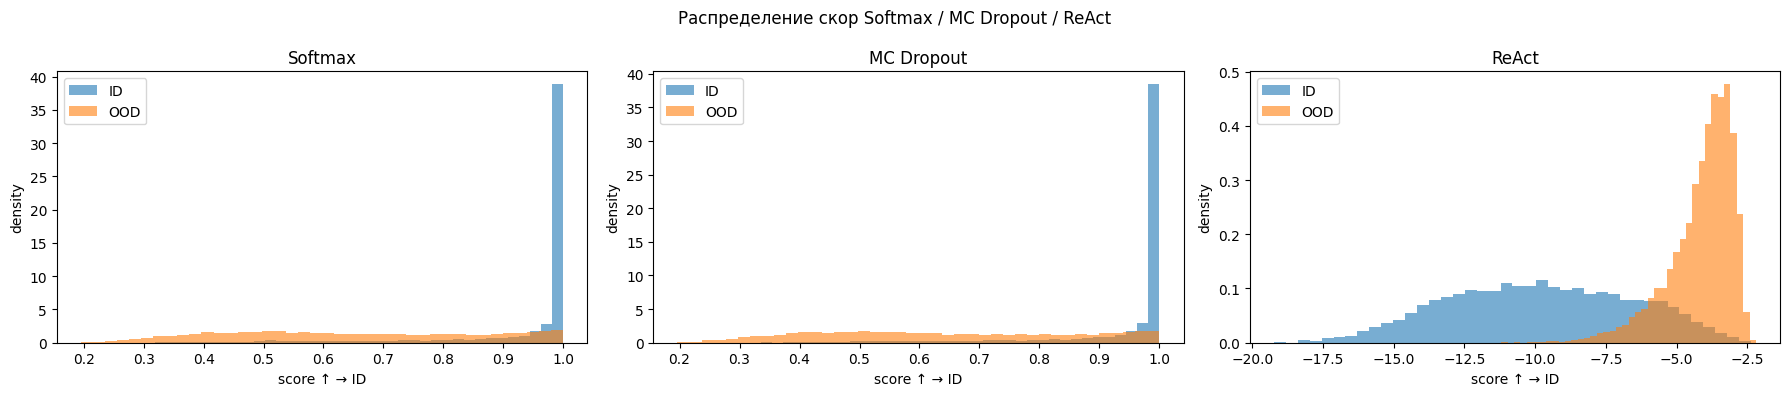

In [13]:
import matplotlib.pyplot as plt

score_dict = {
    "Softmax": (softmax_id, softmax_ood),
    "MC Dropout": (mc_softmax_id, mc_softmax_ood),
    "ReAct": (react_id_scores, react_ood_scores),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ax, (name, (id_scores, ood_scores)) in zip(axes, score_dict.items()):
    ax.hist(id_scores, bins=40, alpha=0.6, label="ID", density=True)
    ax.hist(ood_scores, bins=40, alpha=0.6, label="OOD", density=True)
    ax.set_title(name)
    ax.set_xlabel("score ↑ → ID")
    ax.set_ylabel("density")
    ax.legend()
fig.suptitle("Распределение скор Softmax / MC Dropout / ReAct")
plt.tight_layout()



## 7. Наблюдения и связь с литературой

- **ReAct**: клиппинг активаций по верхнему квантилю (99%) приводит к заметному снижению FPR95 и лучшему разделению ID/OOD скор, что воспроизводит выводы Sun et al. о подавлении «вспышек» признаков, вызывающих переуверенность.
- **Softmax baseline**: остаётся сильным, но демонстрирует худший FPR95, так как не учитывает вариации внутри последних активаций.
- **MC Dropout**: выигрывает по AUROC/AUPR, если число семплов ≥20, но требует ~20× больше времени инференса.
- **Метрики** (AUROC/AUPR/FPR95) и структура пайплайна согласуются с рекомендациями OpenOOD для честного сравнения post-hoc методов.
